<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/05_multimodality.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/05_multimodality.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Multimodality

While preference data in the form of user-item interactions are the backbone of many recommender systems, such data tends to be sparse in nature. One way to address this sparsity is to look beyond the interaction data to the additional information associated with users or with items. The intuition is that items with similarity in "content profiles" would be correlated with similarity in preferences. Multimodality deals with how to model both preference data (one modality) and some content data either on user or item side (other modalities). In this tutorial, we see three forms of additional modalities, namely graph, text, and image, and investigate whether they add value to the the resulting recommendations.

## 1. Setup

In [1]:
!pip install --quiet cornac

In [2]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd; pd.set_option("max_colwidth", 0);
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.utils import cache
from cornac.datasets import filmtrust, amazon_clothing
from cornac.eval_methods import RatioSplit
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Cornac version: 2.1
Tensorflow version: 2.15.0


## 2. Graph Modality

In recommender systems, graph can be used to represent user social network or item contexts (e.g., co-views, co-purchases).  In this tutorial, we take the former as an example and discuss SoRec [2], a representative model for this class of algorithms.


### Social Recommendation (SoRec)

SoRec model is based on matrix factorization framework. The idea is fusing user-item rating matrix with the user’s social network.  In summary, the *user-item rating matrix* ($R$) and the *user-user graph adjacency matrix* ($G$) are factorized with shared users' latent factors.  The user latent vectors in $\mathbf{U}$ are shared to capture both user preferences as well as their social connections.  The rating prediction is obtained as $\hat{r}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j$, similarly to PMF model.

To learn the model parameters, we minimize the following loss function:

$$ \mathcal{L}(\mathbf{U,V,Z}|\lambda,\lambda_C) = \frac{1}{2} \sum_{r_{i,j} \in \mathcal{R}} (r_{i,j} - \mathbf{u}_i^T \mathbf{v}_j)^2 + \frac{\lambda_C}{2} \sum_{g_{i,h} \in \mathcal{G}} (g_{i,h} - \mathbf{u}_i^T \mathbf{z}_h)^2 + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} ||\mathbf{v}_j||^2 + \frac{\lambda}{2} \sum_{h=1}^{N} ||\mathbf{z}_h||^2 $$

where $\lambda_C$ is the relative importance of the social network factorization and $\lambda$ is the regularization weight.

Let's do a comparison between SoRec and its base model PMF on [FilmTrust dataset](http://konect.cc/networks/librec-filmtrust-trust/).

In [3]:
K = 20
sorec = SoRec(k=K, max_iter=50, learning_rate=0.001, verbose=VERBOSE, seed=SEED)
pmf = PMF(k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED)

ratings = filmtrust.load_feedback()
trust = filmtrust.load_trust()

user_graph_modality = GraphModality(data=trust)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=2.5,
    exclude_unknowns=True,
    user_graph=user_graph_modality,
    verbose=VERBOSE,
    seed=SEED,
)

mae = cornac.metrics.MAE()

cornac.Experiment(eval_method=ratio_split, models=[sorec, pmf], metrics=[mae]).run()

/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 3 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
      |    MAE | Train (s) | Test (s)
----- + ------ + --------- + --------
SoRec | 0.6644 |    1.4861 |   0.4650
PMF   | 0.7018 |    0.9751 |   0.4134



From the experiment, we see that SoRec achieves lower (better) MAE score as compared to PMF.  This improvement should be explained by useful information from user social network captured inside the model predictions.  Let's take a look at user factors and see if there are connections to the social network.  

### Interpreting Recommendation

Below is the variance of each user latent dimension.

<Axes: xlabel='Factor', ylabel='Variance'>

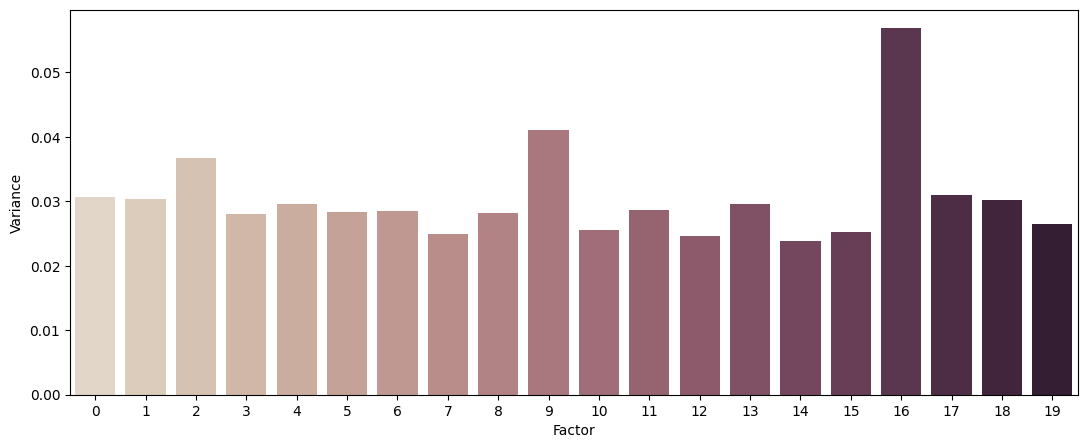

In [4]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(sorec.U, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, hue="Factor", palette="ch:.25", ax=ax, legend=False)

Let's select two dimensions and see how users are distributed in that 2D space.  In addition, we can visualize connections between two users if they are linked in the social network.

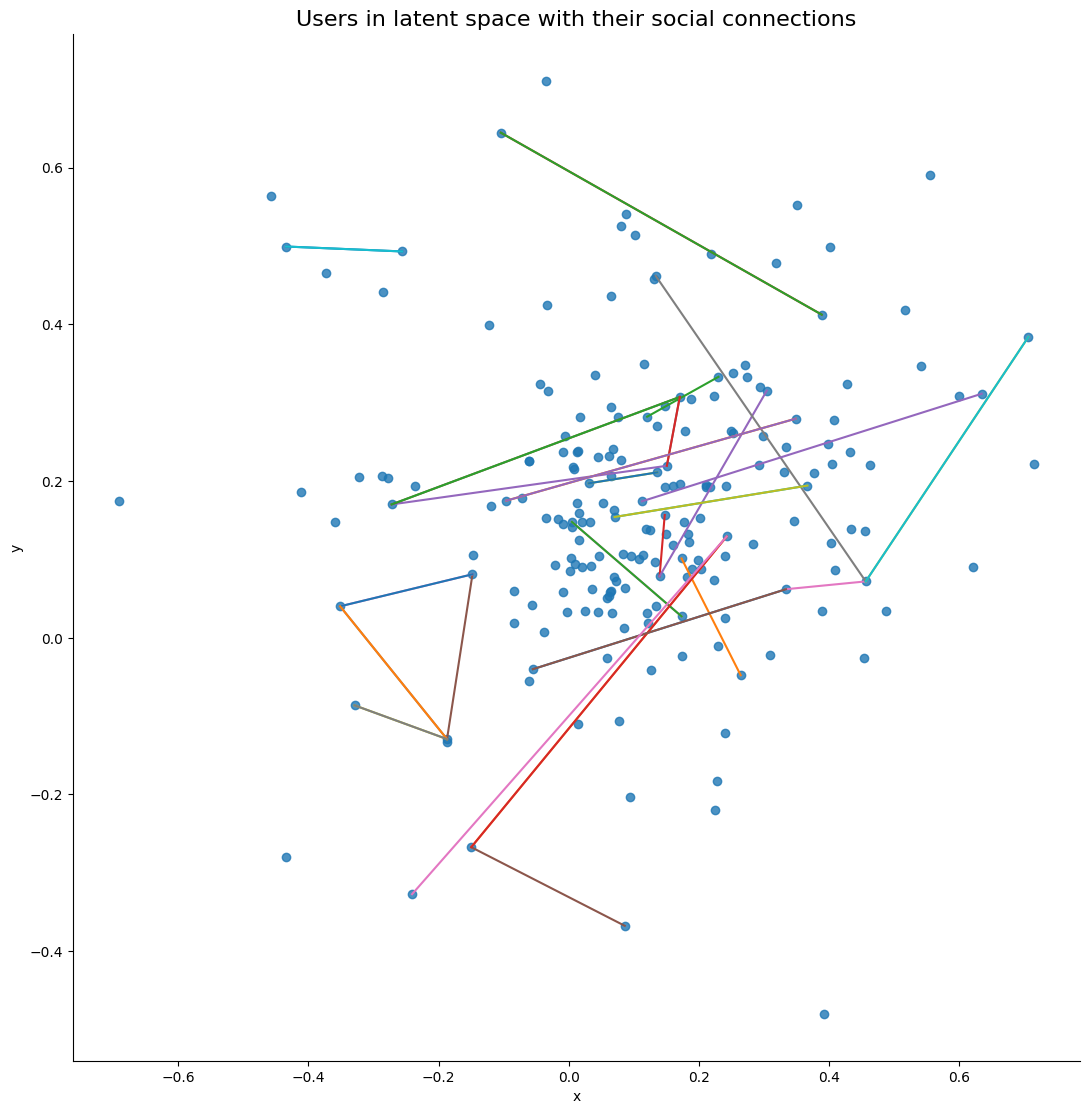

In [5]:
TOP2F = (9, 19)
SAMPLE_SIZE = 200

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(sorec.U.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=sorec.U[sample_inds][:, TOP2F], columns=["x", "y"])
g = sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
g.ax.set_title("Users in latent space with their social connections", fontsize=16)

adj_mat = sorec.train_set.user_graph.matrix
for i in range(len(sample_inds)):
  for j in range(len(sample_inds)):
    if j != i and adj_mat[sample_inds[i], sample_inds[j]]:
      sns.lineplot(x="x", y="y", data=sample_df.loc[[i, j]])

There are indeed some locality of user connections shown in the figure above. That suggests social network information is captured in the user latent factors and has some influence on the recommendations by the SoRec model.

## 3. Text Modality

Often times, we are interested in building a recommender system for textual items (e.g., news, scientific papers), or items associated with text (e.g., titles, descriptions, reviews).  Text is informative and descriptive, therefore, exploiting textual information for better recommendations is an important topic in recommender systems.  In this tutorial, we introduce CTR [3], a recommendation model that combines matrix factorization and probablistic topic modeling.



### Collaborative Topic Regression (CTR)

Under factorization framework, adoption prediction is in the form of $\hat{r}_{i,j} = \mathbf{u}_i^T \mathbf{v}_j $.  The intuition in CTR model is that two items with similar topics would behave similarly. Thus, item latent factors $\mathbf{v_j}$ is assumed to be drawn from a Normal distribution:

$$
\mathbf{v}_j \sim \mathcal{N}(\mathbf{\theta}_j, \lambda^{-1} \mathbf{I})
$$

where the mean $\mathbf{\theta}_j$ is a vector indicating topic proportions of the item $j$. It is equivalent to:

\begin{align}
\mathbf{v}_j &= \mathbf{\theta}_j + \mathbf{\epsilon}_j \\
\mathbf{\epsilon}_j &\sim \mathcal{N}(\mathbf{0}, \lambda^{-1} \mathbf{I})
\end{align}

Please refer to paper [3] for the generative process of CTR model.


CTR also extends matrix factorization, in which the base model is WMF under implicit feedback setting. The adoption $p_{i,j}$ and confidence $c_{i,j}$ are defined as follows:

\begin{equation}
p_{i,j} =
\begin{cases}
r_{i, j} &\mbox{if } r_{i,j} > 0 \\
0 & \mbox{otherwise}
\end{cases}
\end{equation}


\begin{equation}
c_{i,j} =
\begin{cases}
a & \mbox{if } r_{i,j} > 0 \\
b & \mbox{otherwise }
\end{cases}
\end{equation}

The learning of CTR model is done via minimizing the following negative log-likelihood:

$$ \mathcal{L}(\mathbf{U,V,\theta, \beta}|\lambda) = \frac{1}{2} \sum_{i,j} c_{i,j} (p_{i,j} - \mathbf{u}_i^T \mathbf{v}_j)^2 - \sum_{j}\sum_{n} \log \big( \sum_{k=1}^K \mathbf{\theta}_{j,k} \mathbf{\beta}_{k,w_{jn}} \big) + \frac{\lambda}{2} \sum_{i=1}^{N} ||\mathbf{u}_i||^2 + \frac{\lambda}{2} \sum_{j=1}^{M} (\mathbf{v}_j - \mathbf{\theta}_j)^T (\mathbf{v}_j - \mathbf{\theta}_j) $$

It is an iterative procedure of alternating between three steps:
- Optimize for user and item latent vectors, $\mathbf{u}_i$ and $\mathbf{v}_j$, based on the current topic proportions $\mathbf{\theta}_j$.  
- Optimize for topic proportions $\mathbf{\theta}_j$ based on the current vectors $\mathbf{u}_i$ and $\mathbf{v}_j$ and topic words $\mathbf{\beta}_k$.
- Optimize for topic words $\mathbf{\beta}_k$ based on the current topic proportions $\mathbf{\theta}_i$.

Let's experiment with two models CTR and WMF on a dataset from Amazon Clothing category.  Using this dataset, CTR will learn topics from item description.  

In [6]:
K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=VERBOSE,
    seed=SEED,
)

rec_50 = cornac.metrics.Recall(50)

cornac.Experiment(eval_method=ratio_split, models=[ctr, wmf], metrics=[rec_50]).run()


TEST:
...
    | Recall@50 | Train (s) | Test (s)
--- + --------- + --------- + --------
CTR |    0.2263 |  104.6648 |   0.9040
WMF |    0.1606 |   13.2211 |   0.9466



The results show that CTR model performs significantly better than WMF model in terms of Recall@50, which is due to the contribution of items' textual information.

### Interpreting Recommendation

As CTR is based on topic model, it has intuitive explainability both in terms of model parameters as well as its recommendations. First, we can see what the top words of each topic are, based on learned topic-word distributions $\mathbf{\beta}$:

In [7]:
vocab = ctr.train_set.item_text.vocab
topic_word_dist = ctr.model.beta.T[:, -ctr.train_set.item_text.max_vocab:]
top_word_inds = np.argsort(topic_word_dist, axis=1) + 4  # ingore 4 special tokens

topic_words = {}
topic_df = defaultdict(list)
print("WORD TOPICS:")
for t in range(len(topic_word_dist)):
  top_words = vocab.to_text(top_word_inds[t][-10:][::-1], sep=", ")
  topic_words[t+1] = top_words
  topic_df["Topic"].append(t + 1)
  topic_df["Top words"].append(top_words)
topic_df = pd.DataFrame(topic_df)
topic_df

WORD TOPICS:


,Topic,Top words
0,1,"belt, flatlock, case, size, better, choose, earrings, soft, warm, collar"
1,2,"shirt, style, breathable, princess, youre, colors, quality, come, people, socks"
2,3,"easy, collection, colors, rubber, water, quickly, stretch, lightweight, design, body"
3,4,"activities, handle, helmet, star, way, flat, makes, day, half, tee"
4,5,"fit, sweat, mesh, large, pocket, fleece, body, necklace, imported, travel"
5,6,"wicks, material, dry, fit, panels, piece, insect, construction, durability, standard"
6,7,"support, company, fabric, apparel, fun, sizes, hip, outdoor, fiber, features"
7,8,"x, merino, sleeve, fun, items, water, weather, bracelets, comfortable, display"
8,9,"great, performance, black, pockets, inches, make, away, design, jewelry, unique"
9,10,"fits, sun, store, engineered, pocket, shield, conditions, mobility, hat, maximum"


As item vectors are close to its topic proportions, user vectors can also be used to explain what topics they are interested in.

In [8]:
UIDX = 123
TOPK = 5

item_id2idx = ctr.train_set.iid_map
item_idx2id = list(ctr.train_set.item_ids)

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 123 TOP-3 TOPICS:


,Topic,Top words
14,15,"high, storage, height, waistband, wide, way, chest, include, growth, new"
13,14,"size, comfortable, product, warm, need, ua, accessory, clean, footwear, silver"
12,13,"s, use, sure, soft, comfort, easy, products, skin, displays, moisture"


Those are the topics most relevant to her interests. What will be recommendations to this user?

In [9]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 123:


,URL,Description
0,https://www.amazon.com/dp/B002M62ES6,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.
1,https://www.amazon.com/dp/B002MKPKFG,"This glamorous dress is perfect for a night at the ball. The stretchy blue velvet bodice is elegantly detailed with a gathered white inlay, ruffled cap sleeves, sparkling silver trim and a white rose. The silver trimmed waist drapes outlined with ruffle capture that authentic Cinderella look.The dress is designed with an empire waist that sits 1.5 inches above the waist. They are machine washable and made for long repeated use, unlike many one-off Halloween costumes that are not made for everyday play. Our stretchy accommodating fabrics will allow for a comfortable fit for each child within the respective age ranges and there are no itchy fabrics or trims.Each dress comes with an exclusive Princess Hairbow as part of the bundle set."
2,https://www.amazon.com/dp/B001NAHW2U,LACY 14K GOLD on 925 Silver Charm BEAD compatible with European Bracelet
3,https://www.amazon.com/dp/B000HS6NEC,"Includes jacket, elastic pants, hat, belt, whistle, and gun holster. Child Size Small (4-6)."
4,https://www.amazon.com/dp/B001EDF3OU,The Child Indiana Jones Hat and Whip are two must have accessories for your child's Officially Licensed Indiana Jones costume. This Indiana Jones costume accessory contains the two hallmarks of Indy's style: his awesome whip and his trademark hat.


Interestingly, in the desctiption of top-5 recommendations, we see words relevant to the user's topics (e.g., *Accessorize, Gloves, Bracelet, Silver*). This would suggest that CTR model can capture user preferences via the notions of item topics.

---

Let's check out another user with *index = 321*. Similarly, we see the top-3 topics this user cares most about:

In [10]:
UIDX = 321

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 321 TOP-3 TOPICS:


,Topic,Top words
19,20,"complete, wear, fabric, features, display, measures, merino, technology, gift, want"
2,3,"easy, collection, colors, rubber, water, quickly, stretch, lightweight, design, body"
10,11,"costume, products, small, inside, classic, lightweight, comfort, white, ideal, designed"


The topics include clothing with certain characteristics (*easy, water, stretch, lightweight, comfort*).

Based on this, how would the model give recommendations to the user?

In [11]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 321:


,URL,Description
0,https://www.amazon.com/dp/B000MARQFA,"You demand a lot from your pants when you're on the move and the PROPPER Tactical Pant delivers. Nine pockets hold everything from your smartphone to your multi-tool. Rugged canvas fabric offers durability and strength, with DuPont Teflon fabric protector to repel stains and liquids. An action-stretch waistband adds comfort. And with our innovative wallet ""pocket in a pocket"" you'll appreciate not sitting on your wallet all day long. Come with a free matching belt (12.99 value)."
1,https://www.amazon.com/dp/B001VIH648,"You demand a lot from your pants when you're on the move and the PROPPER Tactical Pant delivers. Nine pockets hold everything from your smartphone to your multi-tool. Rugged canvas fabric offers durability and strength, with DuPont Teflon fabric protector to repel stains and liquids. An action-stretch waistband adds comfort. And with our innovative wallet ""pocket in a pocket"" you'll appreciate not sitting on your wallet all day long. Come with a free matching belt (12.99 value)."
2,https://www.amazon.com/dp/B002V44LTO,"Sleeves - Made From 50% nylon & 50% cotton. Chest & Back - Made from 40% Acrylic & 60% Cotton. Resists melting & dripping. Melting point is rated to 230 degrees Fahrenheit. Moisture wicking. Lightweight & breathable. Zippered sleeve storage pockets. Mock turtle neck. Anti abrasion padded elbow patches. Gusseted sleeves. Glint tape holder for IR tape. Loop on sleeve pockets for attaching name, rank and flag. Colors Available: Black, ACU Digital Camouflage, Olive Drab, Desert Digital Camouflage & Digitial Woodland Camouflage. Sizes to choose from: Small, Medium, Large, X-Large, 2X-Large & 3X-Large."
3,https://www.amazon.com/dp/B002FIVZD6,"TRU-SPEC is one of the leading suppliers of uniforms and personal equipment to military, law enforcement and public safety markets.&#xA0; Thousands of police, firefighters, EMTs and military personnel use and depend on our products daily. The name TRU-SPEC has become synonymous with quality, innovation and service. Gunnery Sgt. R. Lee Ermey, USMC (Ret.) known as ""The Gunny"" has become the official celebrity spokesperson for TRU-SPEC's line of tactically inspired apparel."
4,https://www.amazon.com/dp/B00062B1IC,"The PROPPER BDU trouser offers an authentic military cut in comfortable, durable Battle Rip fabric. Sewn to military specification, this button-fly BDU is fade, shrink and wrinkle resistant. It features felled seams and reinforced seat and knee for maximum durability. Six pockets with fused pocket flaps ensure a clean, professional look. With adjustable waist tabs and durable drawstring leg closures for a secure fit."


From the top-5 recommendations, we notice that those items are *military/outdoor/sports* clothing, based on their descriptions as well as the URL to Amazon website. That is also evident from the user's topics that we observe above.

## 4. Image Modality

In some contexts, item images are informative (e.g., fashion). With the existence of effective methods to learn image representation, using item images in recommender systems is gaining popularity. In this tutorial, we present VBPR [4], a recommendation model making use of item image features extracted from pre-trained Convolutional Neural Network (CNN).

### Visual Bayesian Personalized Ranking (VBPR)

VBPR, which is also based on matrix factorization, is an extension of BPR model.  The novelty of VBPR is on how item visual features incorporated into the matrix factorization framework.  The preference score user $i$ giving to item $j$ is predicted as follows:

$$
\hat{r}_{i,j} = \alpha + b_i + b_j + \mathbf{u}_i^T \mathbf{v}_j + \mathbf{p}_{i}^T(\mathbf{E} \times \mathbf{f}_j) + \mathbf{\Theta}^T \mathbf{f}_j
$$

where:
- $\alpha, b_i, b_j$ are global bias, user bias, and item bias, respectively
- $\mathbf{u}_i \in \mathbb{R}^K$ and $\mathbf{v}_j \in \mathbb{R}^K$ are user and item latent vectors, respectively
- $\mathbf{f}_j \in \mathbb{R}^D$ is the item image feature vector
- $\mathbf{p}_i \in \mathbb{R}^Q$ is user visual preference, and $(\mathbf{E} \times \mathbf{f}_j) \in \mathbb{R}^Q$ is item visual representation with $\mathbf{E} \in \mathbb{R}^{K \times D}$ is the projection from visual feature space into preference space
- $\mathbf{\Theta} \in \mathbb{R}^D$ is global visual bias vector

Learning parameters of VBPR model can be done, similarly to BPR, via minimizing the following negative log-likelihood:

$$ \mathcal{L}(\mathbf{U,V,b,E,\Theta, P}|\lambda) = \sum_{(j >_i l) \in \mathbf{S}} \ln (1 + \exp\{-(\hat{r}_{i,j} - \hat{r}_{i,l})\}) + \frac{\lambda}{2} \sum_{i=1}^{N} (||\mathbf{u}_i||^2 + ||\mathbf{p}_i||^2) + \frac{\lambda}{2} \sum_{j=1}^{M} (b_j + ||\mathbf{v}_j||^2) + \frac{\lambda}{2} ||\mathbf{\Theta}||^2 + \frac{\lambda}{2} ||\mathbf{E}||^2_2 $$

Noted that global bias $\alpha$ and user bias $b_i$ do not affect the ranking of items, thus they are redundant and removed from the model parameters.

Let's compare VBPR and BPR models with an experiment on Amazon Clothing dataset.


In [12]:
K = 10
vbpr = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)
bpr = BPR(k=(K * 2), max_iter=50, learning_rate=0.001, lambda_reg=0.001, verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
img_features, item_ids = amazon_clothing.load_visual_feature()

item_image_modality = ImageModality(features=img_features, ids=item_ids, normalized=True)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_image=item_image_modality,
    verbose=VERBOSE,
    seed=SEED,
)

auc = cornac.metrics.AUC()

cornac.Experiment(eval_method=ratio_split, models=[vbpr, bpr], metrics=[auc]).run()

Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/image.zip
will be cached into /root/.cornac/amazon_clothing/image_features.npy


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/item_ids.zip
will be cached into /root/.cornac/amazon_clothing/item_ids.txt


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Optimization finished!

TEST:
...
     |    AUC | Train (s) | Test (s)
---- + ------ + --------- + --------
VBPR | 0.7053 |   39.0730 |   1.2915
BPR  | 0.5992 |    0.0938 |   1.1770



The results show that VBPR obtains higher performance than BPR in terms of AUC. That can be attributed to the usage of item visual features. Let's try to get some ideas on how the visual features contributing to the model recommendations.

### Interpreting Recommendation

First, let's take a look at items rated by a particular user. Then we see how VBPR model recommends to the user.

In [13]:
UIDX = 111

item_id2idx = vbpr.train_set.iid_map
item_idx2id = list(vbpr.train_set.item_ids)
img_features = vbpr.train_set.item_image.features
item_desc = {iid: desc for desc, iid in zip(*amazon_clothing.load_text())}

print(f"RATED ITEMS BY USER {UIDX}:")
rated_items = np.nonzero(vbpr.train_set.matrix[UIDX].A)[1]
rated_df = defaultdict(list)
for i in rated_items:
  rated_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rated_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rated_df)

RATED ITEMS BY USER 111:


,URL,Description
0,https://www.amazon.com/dp/B00BXQF1XG,"Disguise Boy's Marvel Ultimate Spider-Man Classic Costume, 3T-4T Jumpsuit."
1,https://www.amazon.com/dp/B002M62ES6,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.


In [14]:
TOPK = 5

recommendations, scores = vbpr.rank(UIDX)

print(f"\nTOP {TOPK} RECOMMENDATIONS:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  cf_contrib = vbpr.beta_item[i] + np.dot(vbpr.gamma_item[i], vbpr.gamma_user[UIDX])
  vis_contrib = vbpr.visual_bias[i] + np.dot(vbpr.theta_item[i], vbpr.theta_user[UIDX])
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Score"].append(scores[i])
  rec_df["CF Contribution"].append(cf_contrib)
  rec_df["Visual Contribution"].append(vis_contrib)
  rec_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS:


,URL,Score,CF Contribution,Visual Contribution,Description
0,https://www.amazon.com/dp/B002M62ES6,7.457715,1.116012,6.341703,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.
1,https://www.amazon.com/dp/B007DLVLAW,7.312137,1.509102,5.803035,"Patented elastic shoelace and fastening system. Engineered and designed to improve performance and keep laces locked and secure throughout the course of a race, game, practice, or workout."
2,https://www.amazon.com/dp/B00BHPRRKS,6.589272,-0.176793,6.766066,Jumpsuit with muscle torso and arms attached belt.
3,https://www.amazon.com/dp/B0000CNR1L,6.477899,0.324168,6.153731,"No more digging around in deep toiletries bags for that pair of tweezers or spare safety pin you know is in there somewhere. Made of clear vinyl for quick viewing, the ten compartments on this unique organizer keep everything from dental floss to shaving cream readily retrievable. Organized in four zippered rows, the compartments vary in size and keep contents secure. When empty, the bag folds to a flat 10 by 14 inches. When filled, it can be laid inside a suitcase. The hook allows the bag to be hung inside a garment bag if desired, and then looped over a bathroom door or towel hook for accessibility. Made of PVC microfiber, the bag extends to 28 by 14 inches when fully opened.--Ann Bieri"
4,https://www.amazon.com/dp/B00BXQF1XG,6.426819,0.020040,6.406779,"Disguise Boy's Marvel Ultimate Spider-Man Classic Costume, 3T-4T Jumpsuit."


The recommendations (0, 2, 4), with high visual contribution, are indeed visually similar to the two items rated by the user.  That gives us some intuition on how VPBR model makes use of the item visual features in the predictions.

## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Ma, H., Yang, H., Lyu, M. R., & King, I. (2008, October). Sorec: social recommendation using probabilistic matrix factorization. In Proceedings of the 17th ACM conference on Information and knowledge management (pp. 931-940).
3.   Wang, C., & Blei, D. M. (2011, August). Collaborative topic modeling for recommending scientific articles. In Proceedings of the 17th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 448-456).   
4.   He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.
5.   Cornac - A Comparative Framework for Multimodal Recommender Systems (https://cornac.preferred.ai/)

